In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mxnet
!pip install gluoncv
#Run extractor
%cd /content/drive/MyDrive/
!python cityscapes.py

In [84]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torch
import gluoncv.data
from gluoncv.data import CitySegmentation
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from gluoncv.utils.viz import get_color_pallete

In [5]:
from PIL import Image
class Loader(CitySegmentation):
  def __init__(self, split):
    self.split = split
    super(Loader, self).__init__(split=self.split)
  def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        if self.mode == 'test':
            img = self._img_transform(img)
            if self.transform is not None:
                img = self.transform(img)
            return img, os.path.basename(self.images[index])
        #mask = self.masks[index]
        mask = Image.open(self.mask_paths[index])
        # synchrosized transform
        if self.mode == 'train':
            img, mask = self._sync_transform(img, mask)
        elif self.mode == 'val':
            img, mask = self._val_sync_transform(img, mask)
        else:
            assert self.mode == 'testval'
            img, mask = self._img_transform(img), self._mask_transform(mask)
        # general resize, normalize and toTensor
        if self.transform is not None:
            img = self.transform(img)
        return img.asnumpy(), mask.asnumpy()

In [6]:
train_dataset = Loader(split='train')
test_dataset = Loader(split='val')
test_loader = DataLoader(test_dataset, shuffle=True, drop_last=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)

Found 2975 images in the folder /root/.mxnet/datasets/citys/leftImg8bit/train
Found 500 images in the folder /root/.mxnet/datasets/citys/leftImg8bit/val


In [86]:
joker = iter(test_loader)
sample, label = next(joker)

tensor(18, dtype=torch.int32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  


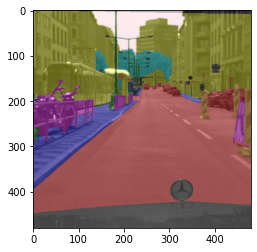

In [97]:
output = sample.numpy().reshape(480, 480, 3)
plt.imshow(output.astype('uint8'))
mask = label.numpy().reshape(480, 480)
# get pallete for the mask
#mask = get_color_pallete(mask, dataset='citys')
#plt.imshow(mask)
from skimage import color
result_image = color.label2rgb(mask, output.astype('uint8'))
plt.imshow(result_image)

In [207]:
#download model only the first time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=False, num_classes=20)

#loaded trained model to train for more epochs
model = torch.load('/content/drive/MyDrive/model.pt')
model = model.to(device)


In [9]:
torch.set_printoptions(threshold=10_000)
def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target 
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''
    
    # Set model to train mode before each epoch
    model.train()
    
    # Empty list to store losses 
    losses = []
    #correct = 0
    
    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample
        
        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        data = data.view(batch_size, -1, 480, 480)
        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()
      
        # Do forward pass for current set of data

        output = model(data)
        output = output['out'] 
        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        #
        # Remove NotImplementedError and assign correct loss function.
        target = target.long()
        target = target + 1
        loss = criterion(output, target)
        
        # Computes gradient based on final loss
        loss.backward()
        
        # Store loss
        losses.append(loss.item())
        
        # Optimize model parameters based on learning rate and gradient 
        optimizer.step()
        
        # Get predicted index by selecting maximum log-probability
        #pred = output.argmax(dim=1, keepdim=True)
        
        #correct += pred.eq(target.data.view_as(pred)).sum()
        
    train_loss = float(np.mean(losses))
    #train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}\n'.format(
        float(np.mean(losses))))
    

    return train_loss, model
    


def test(model, device, test_loader, criterion):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''
    
    # Set model to eval mode to notify all layers.
    model.eval()
    
    losses = []
    correct = 0
    
    # Set torch.no_grad() to disable gradient computation and backpropagation
  
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)
            
            data = data.view(1, -1, 480, 480)
            # Predict for data by doing forward pass
            output = model(data)
            output = output['out']
            # ======================================================================
            # Compute loss based on same criterion as training
            # ----------------- YOUR CODE HERE ----------------------
            #
            # Remove NotImplementedError and assign correct loss function.
            # Compute loss based on same criterion as training 
            target = target.long()
            target = target + 1
            loss = criterion(output, target)
            
            # Append loss to overall test loss
            losses.append(loss.item())
            
            # Get predicted index by selecting maximum log-probability
            #pred = output.argmax(dim=1, keepdim=True)
            
            # ======================================================================
            # Count correct predictions overall 
            # ----------------- YOUR CODE HERE ----------------------
            #
            # Remove NotImplementedError and assign counting function for correct predictions.
            #correct += pred.eq(target.data.view_as(pred)).sum()
            

    test_loss = float(np.mean(losses))
    #accuracy = 100. * correct / len(test_loader.dataset)

    print('\n Test set: Average loss: {:.4f}\n'.format(
        test_loss))
    
    return test_loss


Torch device selected:  cuda
Starting Training...
Epoch number 1
Train set: Average loss: 0.6424


 Test set: Average loss: 0.8883

Epoch number 2
Train set: Average loss: 0.6205


 Test set: Average loss: 0.8533

Epoch number 3
Train set: Average loss: 0.5988


 Test set: Average loss: 0.8437

Epoch number 4
Train set: Average loss: 0.5948


 Test set: Average loss: 0.8243

Epoch number 5
Train set: Average loss: 0.5782


 Test set: Average loss: 0.8109

Epoch number 6
Train set: Average loss: 0.5729


 Test set: Average loss: 0.8217

Epoch number 7
Train set: Average loss: 0.5733


 Test set: Average loss: 0.7950

Epoch number 8
Train set: Average loss: 0.5648


 Test set: Average loss: 0.8238

Epoch number 9
Train set: Average loss: 0.5591


 Test set: Average loss: 0.8098

Epoch number 10
Train set: Average loss: 0.5461


 Test set: Average loss: 0.7893

Epoch number 11
Train set: Average loss: 0.5394


 Test set: Average loss: 0.7787

Epoch number 12
Train set: Average loss: 0.530

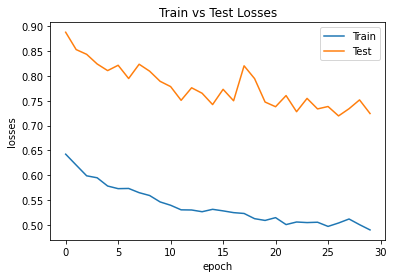

In [12]:

# Check if cuda is available
use_cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
# Set proper device based on cuda availability 
device = torch.device("cuda" if use_cuda else "cpu")
print("Torch device selected: ", device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


best_accuracy = 0.0
train_losses = []
test_losses = []

print("Starting Training...")
# Run training for n_epochs specified in config 
for epoch in range(1, 30 + 1):
    print(f"Epoch number {epoch}")
    train_loss, model = train(model, device, train_loader,
                                        optimizer, criterion, epoch, 4)
    test_loss = test(model, device, test_loader, criterion)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # if test_accuracy > best_accuracy:
    #     best_accuracy = test_accuracy

print("Done Training....")


# print("accuracy is {:2.2f}".format(best_accuracy))
print("Training and evaluation finished")
plt.plot(train_losses)
plt.plot(test_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
plt.show()

In [13]:
torch.save(model, '/content/drive/MyDrive/model_v2.pt')

In [210]:
#pick a 
import time
time_start = time.perf_counter ()
count = 0
for sample, label in test_dataset:
  sample = torch.Tensor(sample).to(device)
  sample = sample.view(1, 3, 480, 480)
  output =  model(sample)
  count  = count + 1
  if count == 2:
    break
time_finish = time.perf_counter()

inference_time = time_finish - time_start
print(f"The inference time is: {inference_time}")

The inference time is: 0.28568491699843435


In [211]:
output = output['out'][0].argmax(0)
output = output.cpu().numpy() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  


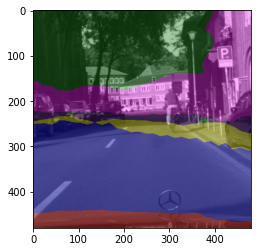

In [212]:
from skimage import color
result_image = color.label2rgb(output, sample.cpu().numpy().reshape(480, 480, 3).astype('uint8'))
plt.imshow(result_image)